In [10]:
import os, math
from collections import defaultdict, namedtuple
import itertools
import sqlite3
import logging
import logging.handlers
import pickle
import datetime

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [11]:
DF_TEST_RESULTS = pd.DataFrame(columns=['test_run_id', 'config_variant', 'cortical_columns', 'train_images_count', 
                                        'source_ds', 'test_image_id', 'true_value', 'infer_value', 'sim'])
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

In [12]:
log = logging.getLogger('kmslog')
log.setLevel(logging.DEBUG)

if not log.hasHandlers():
    log.addHandler(logging.handlers.SysLogHandler(address = '/dev/log', facility=logging.handlers.SysLogHandler.LOG_LOCAL0))

config_var = 'SQLITE3_NORMAL_GRID_0_256'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
print(f'xp = {xp.__name__}')

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name))
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name))

xp = cupy


In [60]:
hdc = Hdc(10_000, xp)

In [14]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.25 μs


((10000, 3), (2000, 3))


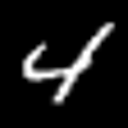
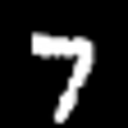
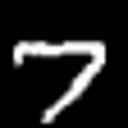
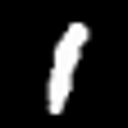
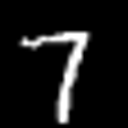
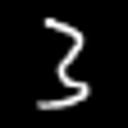
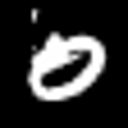
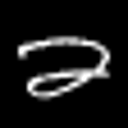
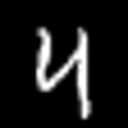
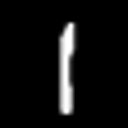
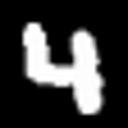
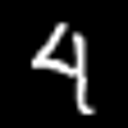
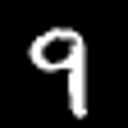
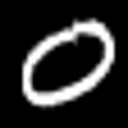
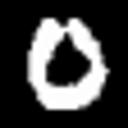
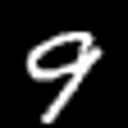

In [15]:
count = 8

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    image_datas = df.loc[image_ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[image_ids]['value']
    return images, list(labels)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [62]:
class Engram(object):
    def __init__(self):
        self.hdv_bundle_uncapped_ = None
        self.hdv_bundle = None
        self.image_value = None
        self.image_ids = set()
        self.is_sealed = False
        self.updates_counter = 0

    @property
    def hdv_bundle_uncapped(self):
        return self.hdv_bundle_uncapped_

    @hdv_bundle_uncapped.setter
    def hdv_bundle_uncapped(self, h):
        self.hdv_bundle_uncapped_ = h
        self.hdv_bundle = xp.sign(h)
        self.updates_counter += 1

class CorticalColumn(object):
    def __init__(self):
        # engram = collection of related HDV aka prototype or collective image
        self.engrams = {} # key - index in engram_norms, value - Engram instance
        self.engram_norms = HdvArray(hdc.N, xp) # hot part of computation - normalized versions of engrams for fast cos sim calculation
        self.images_seen = 0

In [68]:
COLUMNS = {}
COLUMNS = {-1: CorticalColumn()}
# COLUMNS.update(map(lambda i: (i, CorticalColumn()), range(1)))
# COLUMNS.update(map(lambda i: (i, CorticalColumn()), range(config.cortical_columns_count)))

In [ ]:
TRAIN_RUN_ID += 1
epochs = 10
attempts_to_get_no_mistakes = 10
count = 1000
consolidation_threshold = 1000

for epoch in tqdm(range(epochs), desc='Epoch'):
    train_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for column_id, column in tqdm(COLUMNS.items(), desc='Column', leave=False):
        for attempt_to_get_no_mistakes in tqdm(range(attempts_to_get_no_mistakes), leave=False, desc='Attempt'):
            # 1) EVOLVE MEMORIES
            for image_no, image_id in tqdm(enumerate(train_step_image_ids), leave=False, total=len(train_step_image_ids), desc='Image (train)'):
                # 1.1) MINE ENGRAMS
                log_prefix = f'[EP={epoch},COL={column_id},TRRID={TRAIN_RUN_ID},IMGNO={image_no},IMGID={image_id}]'
                log.debug(f'{log_prefix} Engrams count={column.engram_norms.len}')
                column.images_seen += 1
                
                image_value = df_train_images.loc[image_id]['value']
                df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id AND column_id=:column_id', 
                                                 params={'image_id': int(image_id), 'column_id': column_id}, con=train_db_con)
                assert len(df_image_encodings) > 0
                image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
                image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
                image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)
        
                cos_sim_matrix = column.engram_norms.array_active @ image_encoding_hdvs_norm.T
                cos_sim_matrix[cos_sim_matrix < Hdc.COS_SIM_THRESHOLD] = 0
                cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image
                
                assert cos_sim_vector.shape == (column.engram_norms.array_active.shape[0],)
                engram_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc
                match_found = False
                match_pos = False
                match_is_updated = False
        
                for pos, engram_id in enumerate(engram_ids_by_match_score):
                    cos_sim_value = cos_sim_vector[engram_id]
                    log.debug(f'{log_prefix} Checking engram #{engram_id}, pos={pos}, sim={cos_sim_value:.2f}')
        
                    if cos_sim_value <= 0:
                        break

                    engram = column.engrams[engram_id]
        
                    if engram.image_value != image_value:
                        log.debug(f'{log_prefix} Match WRONG, engram value={engram.image_value} vs {image_value}')
                    else:
                        log.debug(f'{log_prefix} Match CORRECT, sealed={engram.is_sealed}')
        
                        if not engram.is_sealed:
                            engram.image_ids.add(image_id)
                            image_encoding_hdv_bundle = hdc.bundle(image_encoding_hdvs)
                            # before_sim = hdc.sim(engram.hdv_bundle, image_encoding_hdv_bundle)
                            
                            engram.hdv_bundle_uncapped = xp.sum(xp.vstack([engram.hdv_bundle_uncapped, image_encoding_hdv_bundle]), axis=0)
                            column.engram_norms.array[engram_id] = hdc.normalize(engram.hdv_bundle)
                            
                            # after_sim = hdc.sim(engram.hdv_bundle, image_encoding_hdv_bundle)
    
                            # assert before_sim != 0
                            # sim_chg_ratio = (after_sim / before_sim - 1)
                            
                            # if sim_chg_ratio < 0.01:
                            #     log.debug(f'{log_prefix} engram #{engram_id} (upd. counter={engram.updates_counter}) is sealed, sim change = {100 * sim_chg_ratio:.3f}%')
                            #     engram.is_sealed = True

                            if engram.updates_counter > 200:
                                log.debug(f'{log_prefix} engram #{engram_id} (upd. counter={engram.updates_counter}) is sealed')
                                engram.is_sealed = True
        
                        match_found = True
                        match_pos = pos
                        match_is_updated = not engram.is_sealed
                        break
        
                log.debug(f'{log_prefix} Match found={match_found}, pos={match_pos}, is updated={match_is_updated}')
        
                if (match_found and match_pos == 0) or (match_found and match_is_updated):
                    pass
                else:
                    # Deploy new engram
                    engram_id = column.engram_norms.lease()
                    
                    engram = Engram()
                    engram.hdv_bundle_uncapped = xp.sum(xp.vstack(image_encoding_hdvs), axis=0)
                    engram.image_ids.add(image_id)
                    engram.image_value = image_value
                    
                    column.engram_norms.array[engram_id] = hdc.normalize(engram.hdv_bundle)
                    column.engrams[engram_id] = engram
                    log.debug(f'{log_prefix} New engram {engram_id}')

                # 1.2) CONSOLIDATE ENGRAMS
                if image_no > 0 and image_no % consolidation_threshold == 0:
                    def dump_engram_lengths(when):
                        engram_lengths = list(map(lambda e: len(e.image_ids), column.engrams.values()))
                        engram_lengths = np.unique_counts(engram_lengths)
                        
                        for v, c in zip(reversed(engram_lengths.values), reversed(engram_lengths.counts)):
                            log.debug(f'{log_prefix}[CONSOLIDATION] {when:10} {v:5} {c:5}')
        
                    before_len = column.engram_norms.len()
                    assert before_len == len(column.engrams)
                    
                    log.debug(f'{log_prefix}[CONSOLIDATION] BEFORE engrams count = {before_len}')
                    dump_engram_lengths('BEFORE')
                    
                    engram_ids_to_release = []
                    
                    for engram_id, engram in column.engrams.items():
                        #l = 0.1
                        l = 1
                        exp_distro_level = l * np.exp(-l * len(engram.image_ids))
                        rand_level = RNG.random()
                        do_release = rand_level < exp_distro_level
                        
                        if do_release:
                            engram_ids_to_release.append(engram_id)
                            log.debug(f'{log_prefix}[CONSOLIDATION] Dropping engram #{engram_id}, len={len(engram.image_ids)}: {rand_level:.5f} < {exp_distro_level:.5f}')
                
                    for engram_id_to_release in engram_ids_to_release:
                        del column.engrams[engram_id_to_release]
                        column.engram_norms.release(engram_id_to_release)
                
                    after_len = column.engram_norms.len()
                    assert after_len == len(column.engrams)
                    
                    log.debug(f'{log_prefix}[CONSOLIDATION] AFTER engrams count = {after_len}')
                    dump_engram_lengths('AFTER')

            # 2) DETECT MISTAKES FOR CONSEQUENT FIX
            mistake_image_ids = []
            
            for image_no, image_id in tqdm(enumerate(train_step_image_ids), leave=False, total=len(train_step_image_ids), desc='Image (test)'):
                image_value = df_train_images.loc[image_id]['value']
                df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id AND column_id=:column_id', 
                                                 params={'image_id': int(image_id), 'column_id': column_id}, con=train_db_con)
                assert len(df_image_encodings) > 0
                image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
                image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
                image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)
            
                cos_sim_matrix = column.engram_norms.array_active @ image_encoding_hdvs_norm.T
                cos_sim_matrix[cos_sim_matrix < Hdc.COS_SIM_THRESHOLD] = 0
                cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image
                
                assert cos_sim_vector.shape == (column.engram_norms.array_active.shape[0],)
                engram_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc
            
                if engram_ids_by_match_score.shape[0] > 0:
                    engram_id = engram_ids_by_match_score[0]
                    cos_sim_value = cos_sim_vector[engram_id]
            
                    if cos_sim_value > 0:
                        engram_image_value = column.engrams[engram_id].image_value
    
                        if engram_image_value != image_value:
                            mistake_image_ids.append(image_id)

            log.debug(f'[EP={epoch},COL={column_id},TRRID={TRAIN_RUN_ID}] Mistaken image ids = {len(mistake_image_ids)}')
            train_step_image_ids = mistake_image_ids

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Column:   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Column:   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Column:   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Column:   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
def softmax(x):
    max_x = np.max(x)
    exp_x = np.exp(x - max_x)
    sum_exp_x = np.sum(exp_x)
    return exp_x / sum_exp_x

def conflate(pdfs):    
    n = np.prod(pdfs, axis=0)
    d = n.sum()

    if np.isclose(d, 0):
        return np.zeros(len(pdfs))
        
    return n / d

In [41]:
# TEST RUN
TEST_RUN_ID += 1
count = 2000
test_run_source = (df_test_images, test_db_con, 'test')
# test_run_source = (df_train_images, train_db_con, 'train')
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
test_result_rows = defaultdict(list)

for image_id in tqdm(test_image_ids):
    for column_id, column in COLUMNS.items():
        max_cos_sim_index = -1 # aka engram id
        max_similar_engram_image_value = ''
        max_cos_sim = 0
    
        image_value = test_run_source[0].loc[image_id]['value']
        df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id AND column_id=:column_id', 
                                         params={'image_id': int(image_id), 'column_id': column_id}, con=test_run_source[1])
        assert len(df_image_encodings) > 0
        image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
        image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
        image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)
    
        cos_sim_matrix = column.engram_norms.array_active @ image_encoding_hdvs_norm.T
        cos_sim_matrix[cos_sim_matrix < Hdc.COS_SIM_THRESHOLD] = 0
        cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image
        
        assert cos_sim_vector.shape == (column.engram_norms.array_active.shape[0],)
        engram_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc
    
        if engram_ids_by_match_score.shape[0] > 0:
            engram_id = engram_ids_by_match_score[0]
            cos_sim_value = cos_sim_vector[engram_id]
    
            if cos_sim_value > 0:
                max_cos_sim_index = engram_id
                max_similar_engram_image_value = column.engrams[engram_id].image_value
                max_cos_sim = cos_sim_value
    
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append(COLUMNS.keys())
    test_result_rows['train_images_count'].append(column.images_seen) # TODO: fix
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['infer_value'].append(max_similar_engram_image_value) # TODO: fix
    test_result_rows['sim'].append(max_cos_sim) # TODO: fix
    

assert set(test_result_rows.keys()) == set(DF_TEST_RESULTS.columns), set(test_result_rows.keys()) ^ set(DF_TEST_RESULTS.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=DF_TEST_RESULTS.columns)
concat_list = [DF_TEST_RESULTS] if len(DF_TEST_RESULTS) > 0 else []
concat_list.append(df_test_results_for_run)
DF_TEST_RESULTS = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

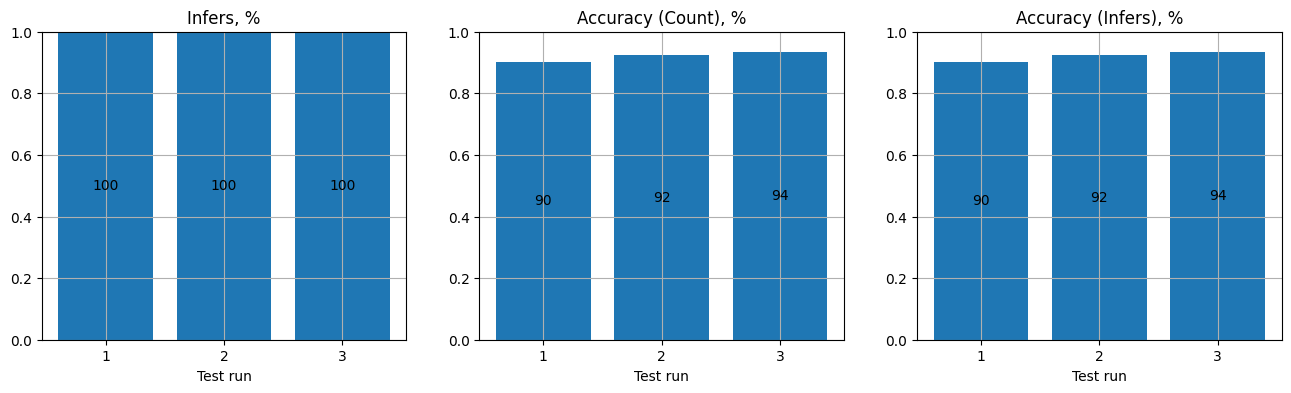

,config_variant,source_ds,cortical_columns,train_images_count,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,
1,SQLITE3_NORMAL_GRID_0_256,test,(-1),12168,2000,2000,1805,1.0,0.9025,0.9025
2,SQLITE3_NORMAL_GRID_0_256,test,(-1),22704,2000,2000,1847,1.0,0.9235,0.9235
3,SQLITE3_NORMAL_GRID_0_256,test,(-1),42956,2000,2000,1870,1.0,0.9350,0.9350


In [42]:
df_test_results2 = DF_TEST_RESULTS.copy()
df_test_results2['is_infer'] = df_test_results2['infer_value'] != -1
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [ ]:
df_test_results_incorrect_infers = df_test_results_for_run[df_test_results_for_run['true_value'] != df_test_results_for_run['infer_value']]
incorrect_infer_row_index = RNG.choice(df_test_results_incorrect_infers.index.unique())
incorrect_infer_row = df_test_results_incorrect_infers.loc[incorrect_infer_row_index]
test_run_id = incorrect_infer_row['test_run_id']
incorrect_infer_image_id =incorrect_infer_row['test_image_id']
image_data = test_run_source[0].loc[incorrect_infer_image_id]['png']
image_value = test_run_source[0].loc[incorrect_infer_image_id]['value']

# df_x = pd.DataFrame(columns=['test_run_id', 'test_image_id', 'true_value', 'infer_value'] + list(map(lambda x: f'd{x}', range(DIGITS.shape[0]))))
# df_x.loc[len(df_x)] = [test_run_id, incorrect_infer_image_id, image_value, incorrect_infer_row['infer_value']] + values
# df_x
f'test_run_id={test_run_id}, test_image_id={incorrect_infer_image_id}, true_value={image_value}, infer_value={incorrect_infer_row['infer_value']}'

# df_x = pd.DataFrame(columns=['test_run_id', 'test_image_id', 'true_value', 'sim'])
# df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(incorrect_infer_image_id)}, con=test_run_source[1])
# assert len(df_image_encodings) > 0
# image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
# image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
# image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)

# cos_sim_matrix = COLUMN.engram_norms.array @ image_encoding_hdvs_norm.T
# cos_sim_matrix[cos_sim_matrix < COS_SIM_THRESHOLD] = 0
# cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image

# assert cos_sim_vector.shape == (COLUMN.engram_norms.array.shape[0],)
# engram_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc

# for pos, engram_id in enumerate(engram_ids_by_match_score):
#     cos_sim_value = cos_sim_vector[engram_id]

#     if cos_sim_value <= 0:
#         break
        
#     engram_image_ids = COLUMN.engram_to_image_ids[engram_id]
#     assert len(engram_image_ids) > 0
#     engram_image_id = next(iter(engram_image_ids))
#     engram_image_value = df_train_images.loc[engram_image_id]['value'] # exactly from train! (i.e. we look for prototype in train data)
#     df_x.loc[len(df_x)] = [test_run_id, incorrect_infer_image_id, image_value, engram_id, engram_image_value, cos_sim_value]

# df_x.sort_values(by='sim', ascending=False).head(10)

In [ ]:
cos_sim_matrices = incorrect_infer_row['sim']

In [ ]:
cos_sim_matrix1 = np.sum(cos_sim_matrices, axis=0) 
cos_sim_matrix2 = cos_sim_matrix1 / len(COLUMNS)
cos_sim_matrix3 = cos_sim_matrix2.copy()
cos_sim_matrix3[cos_sim_matrix3 < (COS_SIM_THRESHOLD * len(COLUMNS) / 2)] = 0
cos_sim_matrix_max_row_index = np.argmax(np.max(cos_sim_matrix3, axis=1))
cos_sim_matrix_max_row_col_index = np.argmax(cos_sim_matrix3[cos_sim_matrix_max_row_index])


In [ ]:
np.round(cos_sim_matrix3[cos_sim_matrix_max_row_index], decimals=1)

In [ ]:
cos_sim_matrix_max_row_index

In [ ]:
np.round(cos_sim_matrix3, decimals=1)

In [ ]:
np.round(cos_sim_matrix2, decimals=1)

In [ ]:
np.round(cos_sim_matrix1, decimals=1)

In [ ]:
image_data = test_run_source[0].loc[incorrect_infer_image_id]['png']
image = Image.open(io.BytesIO(image_data))
label = test_run_source[0].loc[incorrect_infer_image_id]['value']
display_images([image], captions=[label])

In [ ]:
df_x_pivot = pd.pivot_table(df_x, index='engram_id', 
                            values=['true_value', 'engram_value', 'sim'], 
                            aggfunc=dict(engram_value='first', true_value='first', sim='sum'))
df_x_pivot.sort_values(by='sim', ascending=False)

In [ ]:
df_x_pivot = pd.pivot_table(df_x, index='engram_id', 
                            values=['true_value', 'engram_value', 'sim'], 
                            aggfunc=dict(engram_value='first', true_value='first', sim='max'))
df_x_pivot.sort_values(by='sim', ascending=False)

In [ ]:
df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_run_id']

In [ ]:
incorrect_infer_row_index